In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# !pip install statsmodels
# ! pip install prophet

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
# Checking whether the model has captured all the patterns in the data

C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

In [5]:
df=pd.read_csv('AirPassengers.csv')

In [6]:
df.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [7]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.rename(columns={'#Passengers':'Passengers'}, inplace=True)

df.head()


Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [8]:
# time series validation

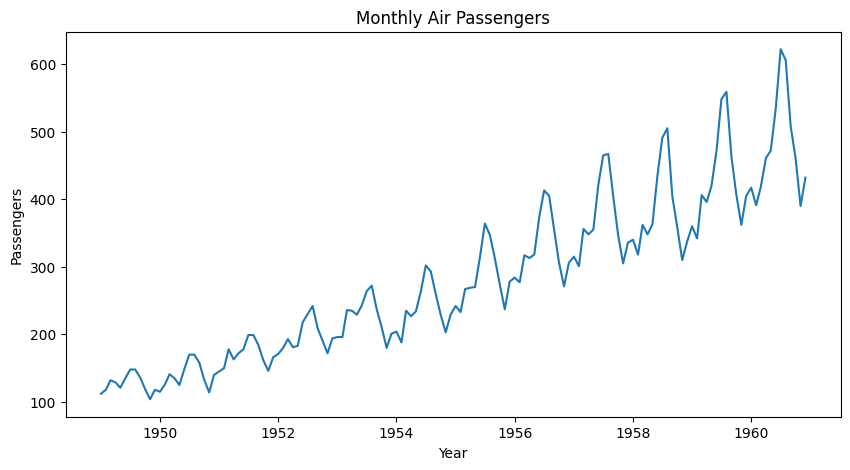

In [9]:
plt.figure(figsize=(10,5))
plt.plot(df['Passengers'])
plt.title("Monthly Air Passengers")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.show()


In [10]:
# checking ADF test (statioary check)
# The ADF test checks whether a time series is stationary.
# Hypotheses:
# H₀ (Null hypothesis): Data is NOT stationary
# H₁ (Alternative): Data IS stationary

In [11]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(df['Passengers'])


ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


In [12]:
# p-value>0.05
# accepting null hypothesis
# non seasonal spikes ARIMA
# seasonal spikes SARIMA

In [13]:
# making series stationary using the log tranformation (removing trend )

In [14]:
# here seasonal fluctuations increasing over time so this is multiplicative seasonality not additive so log transform compress large values , expand small values , stabilize variance 
# converts multiplicative patterns to additive patterns

In [15]:
df['log_passengers'] = np.log(df['Passengers'])
 

In [16]:
# differencing

In [17]:
df['diff_log'] = df['log_passengers'].diff()
df.dropna(inplace=True)


In [18]:
# rechecling the stationary

In [19]:
adf_test(df['diff_log'])


ADF Statistic: -2.717130598388133
p-value: 0.07112054815085875


In [20]:
# ACF and PACF for ARIMA order selection

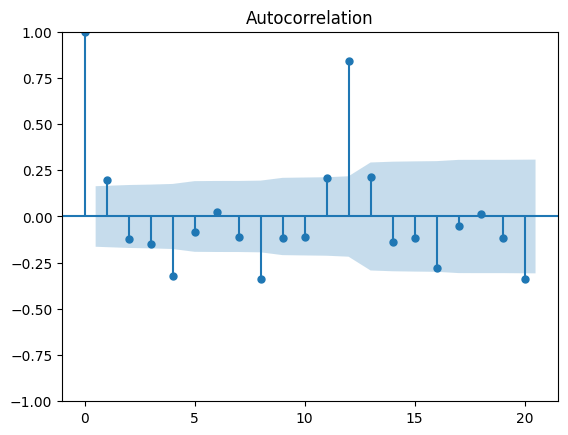

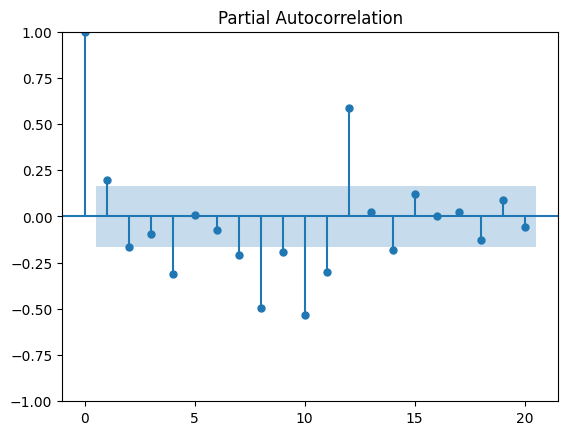

In [21]:
plot_acf(df['diff_log'], lags=20)
plot_pacf(df['diff_log'], lags=20)
plt.show()


In [22]:
train = df.iloc[:-3]
test  = df.iloc[-3:]


In [23]:
# ARIMA implementation  Hyperparameter tuning(AIC)

In [24]:
p = q = range(0, 3)
d = range(0, 2)

pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_arima_order = None

for param in pdq:
    try:
        model = ARIMA(train['log_passengers'], order=param)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_arima_order = param
    except:
        continue

best_arima_order


C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\si

(2, 1, 1)

In [25]:
# arima forecasr
# Train final arima

In [26]:
arima_model = ARIMA(train['log_passengers'], order=best_arima_order)
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=3)
arima_forecast = np.exp(arima_forecast)


# “ARIMA captures trend but struggles with seasonality.”

C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
# SARIMA Hyper parameter tuning(AIC)

In [28]:
# sarima_model = SARIMAX(
#     df['log_passengers'],
#     order=(1,1,1),
#     seasonal_order=(1,1,1,12)
# )
 
# sarima_result = sarima_model.fit()
# print(sarima_result.summary())
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_sarima_params = None

for param in pdq:
    for seasonal in seasonal_pdq:
        try:
            model = SARIMAX(
                train['log_passengers'],
                order=param,
                seasonal_order=seasonal
            )
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_sarima_params = (param, seasonal)
        except:
            continue

best_sarima_params


C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\si

((2, 1, 1), (1, 0, 1, 12))

In [ ]:
# sarima forecast   train final sarima

In [29]:
sarima_model = SARIMAX(
    train['log_passengers'],
    order=best_sarima_params[0],
    seasonal_order=best_sarima_params[1]
)

sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.forecast(steps=3)
sarima_forecast = np.exp(sarima_forecast)


# “SARIMA models both trend and seasonality, making it more suitable.”

C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# fb prophet

In [ ]:
# ds → date

# y → value

In [30]:
prophet_df = df.reset_index()[['Month', 'Passengers']]
prophet_df.columns = ['ds', 'y']


In [31]:
train_p = prophet_df.iloc[:-3]
test_p  = prophet_df.iloc[-3:]

In [32]:
model = Prophet()
model.fit(train_p)

17:26:40 - cmdstanpy - INFO - Chain [1] start processing
17:26:41 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# prophet forecast

In [34]:
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

# business friendly

# “Prophet automatically captures trend, seasonality, and change points.”

C:\Users\T470\AppData\Local\Programs\Python\Python314\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [35]:

prophet_forecast = forecast.tail(3)['yhat'].values

In [36]:
# Accuracy metrics

In [37]:
def metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_metrics   = metrics(test['Passengers'], arima_forecast)
sarima_metrics  = metrics(test['Passengers'], sarima_forecast)
prophet_metrics = metrics(test_p['y'], prophet_forecast)

results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'MAE': [arima_metrics[0], sarima_metrics[0], prophet_metrics[0]],
    'RMSE': [arima_metrics[1], sarima_metrics[1], prophet_metrics[1]],
    'MAPE (%)': [arima_metrics[2], sarima_metrics[2], prophet_metrics[2]]
})

results



Model        MAE       RMSE  MAPE (%)
0    ARIMA  33.708239  42.170933  8.331975
1   SARIMA   8.711979   9.219297  2.003597
2  Prophet  21.841982  26.708157  5.366660

In [38]:
# residual plot sarima

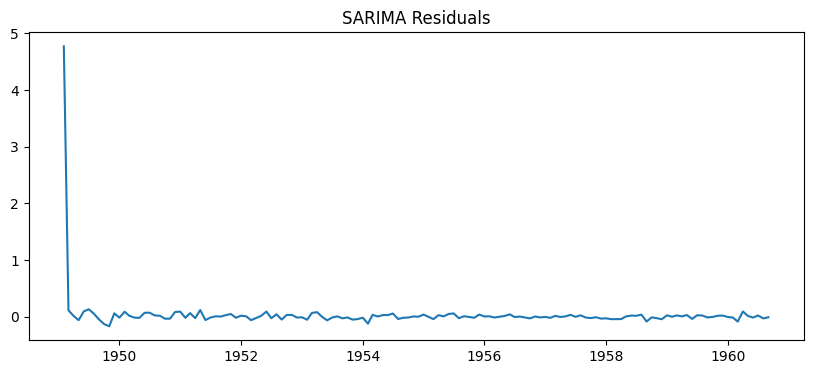

In [39]:
residuals = sarima_fit.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.show()


In [40]:
# residual distrubution 

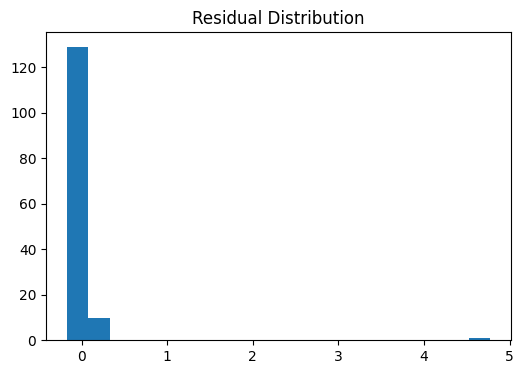

In [41]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20)
plt.title("Residual Distribution")
plt.show()


In [42]:
# residual acf

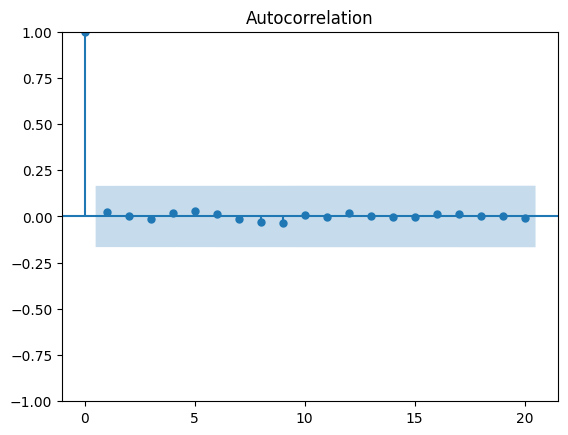

In [43]:
plot_acf(residuals, lags=20)
plt.show()

In [44]:
# ljung box test

In [45]:
from statsmodels.stats.diagnostic import acorr_ljungbox


In [46]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test
# p-value > 0.05 → residuals are white noise

lb_stat  lb_pvalue
10  0.65621   0.999976

In [47]:
# forecast comparision

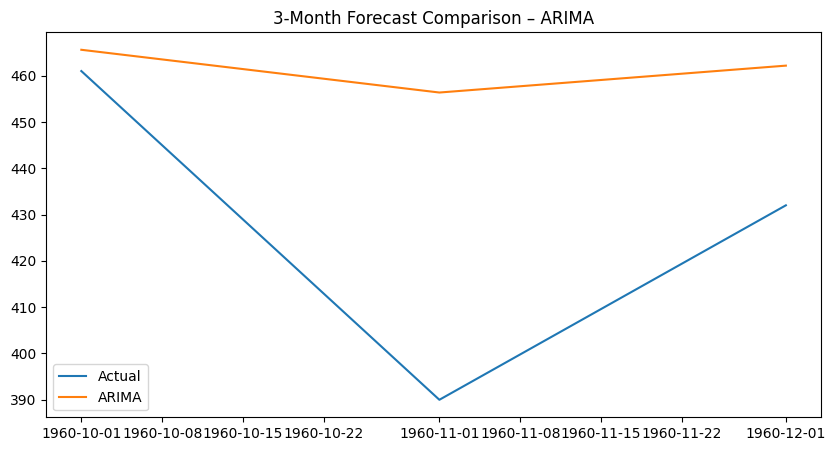

In [48]:
plt.figure(figsize=(10,5))
plt.plot(test['Passengers'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.legend()
plt.title("3-Month Forecast Comparison – ARIMA")
plt.show()


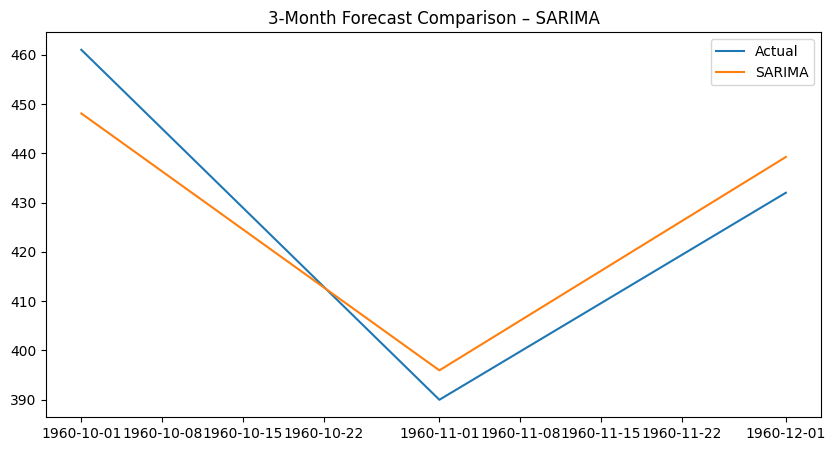

In [49]:
plt.figure(figsize=(10,5))
plt.plot(test['Passengers'], label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA')
plt.legend()
plt.title("3-Month Forecast Comparison – SARIMA")
plt.show()

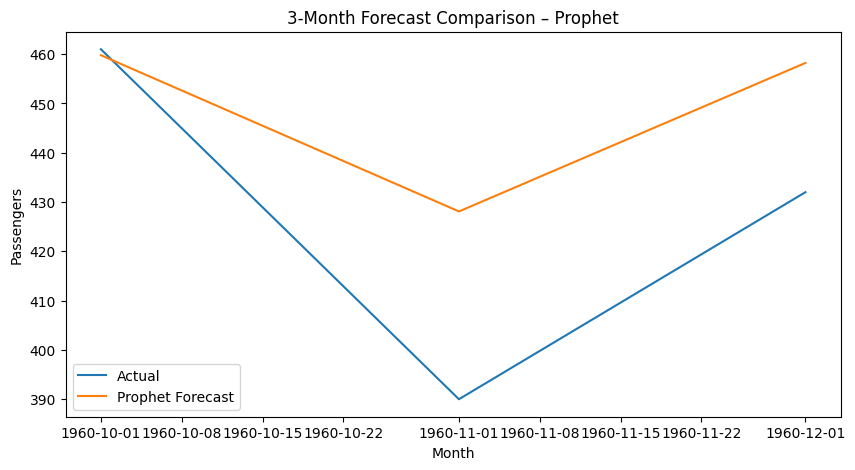

In [50]:
plt.figure(figsize=(10,5))
plt.plot(test_p['ds'], test_p['y'], label='Actual')
plt.plot(test_p['ds'], prophet_forecast, label='Prophet Forecast')
plt.legend()
plt.title("3-Month Forecast Comparison – Prophet")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.show()


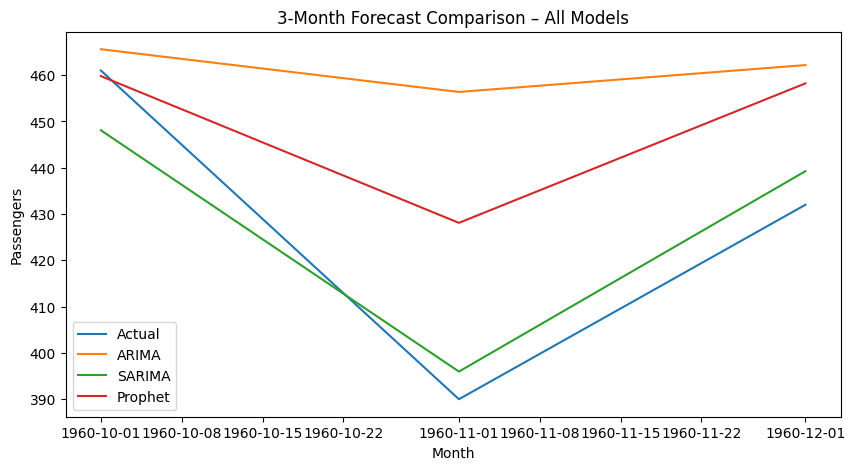

In [51]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test['Passengers'], label='Actual')

plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, sarima_forecast, label='SARIMA')
plt.plot(test_p['ds'], prophet_forecast, label='Prophet')

plt.legend()
plt.title("3-Month Forecast Comparison – All Models")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.show()
